## Workflow plan

 - Create a list of SMILES strings for the molecules reported in reference 10.1021/ed085p532 (Tables 3–5).
 - Develop an RDKit-based query tool that checks whether the current SDF file contains the molecules from the SMILES list.
 - If a given molecule is found in the SDF file, the diamagnetic contribution for that species will be included.

### Materials:
 - [Crack the Code: Mastering SMILES Notation](https://www.youtube.com/watch?v=QRLaIARxP30)
 - [OpenSMILES community - Bible of the SMILES notation](http://opensmiles.org/)
 - [Structure-to-SMILES conventer](https://www.rcsb.org/chemical-sketch)
 - [PubChem - SMILES library](https://pubchem.ncbi.nlm.nih.gov/)

## Imports

In [60]:
from rdkit import Chem
from rdkit.Chem.Draw import MolToImage

from src import SDF_DIR

file = "SDF-to-SMILES.sdf"

## Diamagnetic susceptibilities for molecules

In [61]:
"""
unit: 10^(-6) cm^3/mol
Reference (DOI): 10.1021/ed085p532 (TABLE 5)
This dictionary represents the diamagnetic susceptibilities for common solvent molecules used for crystallization.
Here's a breakdown of the values:
"""
# NOTE: For some molecules, more than one SMILES notation is possible.
# For simplicity, only one SMILES notation was included for each molecule in the dictionary.
# The SMILES strings found in PubChem may not be canonical.
# To ensure consistency, all SMILES in the dictionary were generated by RDKit using the MolFromSmiles function.
# The same function is used to generate SMILES for molecules from SDF file,
# which makes the comparison between dictionary SMILES and SDF-derived SMILES valid.

COMMON_SOLVENTS = {
    "CCl4": {
        "Name": "tetrachloromethane",
        "SMILES": "ClC(Cl)(Cl)Cl",
        "DIAMAG_SUS": -66.8,
    },
    "CHCl3": {
        "Name": "chloroforom",
        "SMILES": "ClC(Cl)Cl",
        "DIAMAG_SUS": -58.9,
    },
    "CH2Cl2": {
        "Name": "dichloromethane",
        "SMILES": "ClCCl",
        "DIAMAG_SUS": -46.6,
    },
    "CH3Cl": {
        "Name": "chloromethane",
        "SMILES": "CCl",
        "DIAMAG_SUS": -32.0,
    },
    "CH3NO2": {
        "Name": "nitromethane",
        "SMILES": "C[N+](=O)[O-]",
        "DIAMAG_SUS": -21.0,  # The overall molecule has neutral charge
    },
    "CH3OH": {
        "Name": "methanol",
        "SMILES": "CO",
        "DIAMAG_SUS": -21.4,
    },
    "CCl3COOH": {
        "Name": "trichloroacetic acid",
        "SMILES": "O=C(O)C(Cl)(Cl)Cl",
        "DIAMAG_SUS": -73.0,
    },
    "CF3COOH": {
        "Name": "trifluoroacetic acid",
        "SMILES": "O=C(O)C(F)(F)F",
        "DIAMAG_SUS": -43.3,
    },
    "CH3CN": {
        "Name": "acetonitrile",
        "SMILES": "CC#N",
        "DIAMAG_SUS": -27.8,
    },
    "1,2-CH2Cl2": {
        "Name": "1,2-dichloroethane",
        "SMILES": "ClCCCl",
        "DIAMAG_SUS": -59.6,
    },
    "CH3COOH": {
        "Name": "acetic acid",
        "SMILES": "CC(=O)O",
        "DIAMAG_SUS": -31.8,
    },
    "CH3CH2OH": {
        "Name": "ethanol",
        "SMILES": "CCO",
        "DIAMAG_SUS": -33.7,
    },
    "HOCH2CH2OH": {
        "Name": "ethylene glycol",
        "SMILES": "OCCO",
        "DIAMAG_SUS": -38.9,
    },
    "CH3CH2SH": {
        "Name": "ethanethiol",
        "SMILES": "CCS",
        "DIAMAG_SUS": -44.9,
    },
    "CH3C(=O)CH3": {
        "Name": "acetone",
        "SMILES": "CC(C)=O",
        "DIAMAG_SUS": -33.8,
    },
    "CH3C(=O)OC(=O)CH3": {
        "Name": "acetic anhydride",
        "SMILES": "CC(=O)OC(C)=O",
        "DIAMAG_SUS": -52.8,
    },
    "CH3CH2CH2CN": {
        "Name": "butyronitrile",
        "SMILES": "CCCC#N",
        "DIAMAG_SUS": -50.4,
    },
    "CH3C(=O)OCH2CH3": {
        "Name": "ethyl acetate",
        "SMILES": "CCOC(C)=O",
        "DIAMAG_SUS": -54.1,
    },
    "CH3CH2CH2CH2OH": {
        "Name": "butanol",
        "SMILES": "CCCCO",
        "DIAMAG_SUS": -56.4,
    },
    "CH3CH2OCH2CH3": {
        "Name": "diethyl ether",
        "SMILES": "CCOCC",
        "DIAMAG_SUS": -55.5,
    },
    "CH3CH2CH2CH2CH3": {
        "Name": "pentane",
        "SMILES": "CCCCC",
        "DIAMAG_SUS": -61.5,
    },
    "1,2-C6H4Cl2": {
        "Name": "o-dichlorobenzene",
        "SMILES": "Clc1ccccc1Cl",
        "DIAMAG_SUS": -84.4,
    },
    "C6H6": {
        "Name": "benzene",
        "SMILES": "c1ccccc1",
        "DIAMAG_SUS": -54.8,
    },
    "C6H12": {
        "Name": "cyclohexane",
        "SMILES": "C1CCCCC1",
        "DIAMAG_SUS": -68,
    },
    "CH3CH2CH2CH2CH2CH3": {
        "Name": "hexane",
        "SMILES": "CCCCCC",
        "DIAMAG_SUS": -74.1,
    },
    "N(CH2CH3)3": {
        "Name": "triethylamine",
        "SMILES": "CCN(CC)CC",
        "DIAMAG_SUS": -83.3,
    },
    "PhCN": {
        "Name": "benzonitrile",
        "SMILES": "N#Cc1ccccc1",
        "DIAMAG_SUS": -65.2,
    },
    "PhCH3": {
        "Name": "toluene",
        "SMILES": "Cc1ccccc1",
        "DIAMAG_SUS": -65.6,
    },
    "CH3C(CH3)2CH2CH(CH3)2": {
        "Name": "isooctane",
        "SMILES": "CC(C)CC(C)(C)C",
        "DIAMAG_SUS": -99.1,
    },
    "C10H8": {
        "Name": "naphthaline",
        "SMILES": "c1ccc2ccccc2c1",
        "DIAMAG_SUS": -91.6,
    },
}

## Convert SMILES to Mol

['ClC(Cl)(Cl)Cl', 'ClC(Cl)Cl', 'ClCCl', 'CCl', 'C[N+](=O)[O-]', 'CO', 'O=C(O)C(Cl)(Cl)Cl', 'O=C(O)C(F)(F)F', 'CC#N', 'ClCCCl', 'CC(=O)O', 'CCO', 'OCCO', 'CCS', 'CC(C)=O', 'CC(=O)OC(C)=O', 'CCCC#N', 'CCOC(C)=O', 'CCCCO', 'CCOCC', 'CCCCC', 'Clc1ccccc1Cl', 'c1ccccc1', 'C1CCCCC1', 'CCCCCC', 'CCN(CC)CC', 'N#Cc1ccccc1', 'Cc1ccccc1', 'CC(C)CC(C)(C)C', 'c1ccc2ccccc2c1']


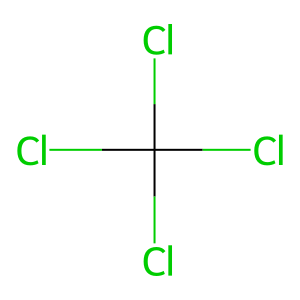

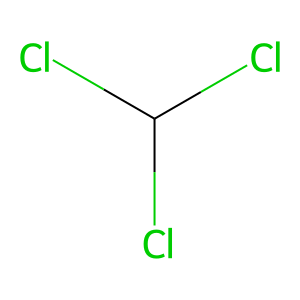

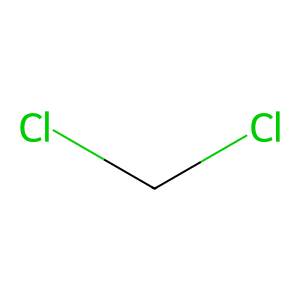

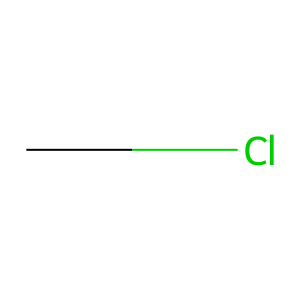

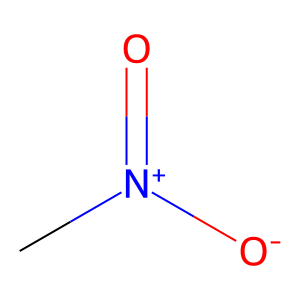

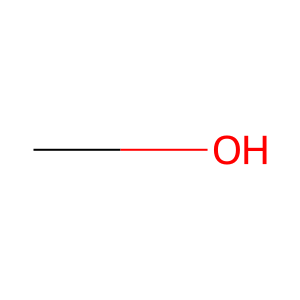

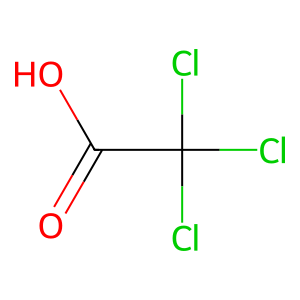

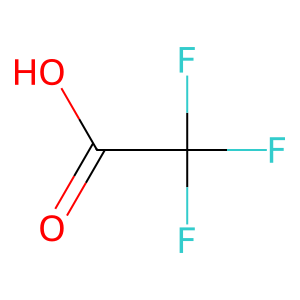

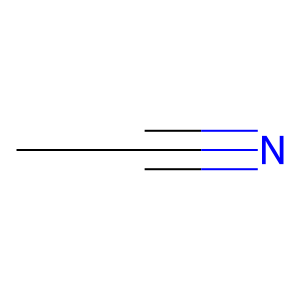

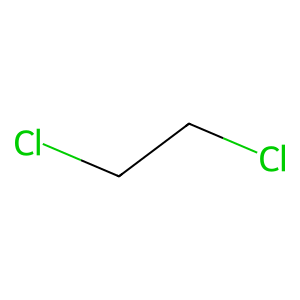

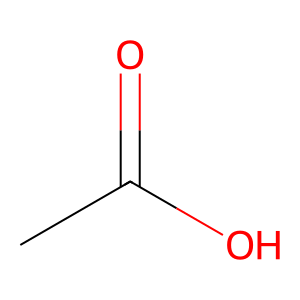

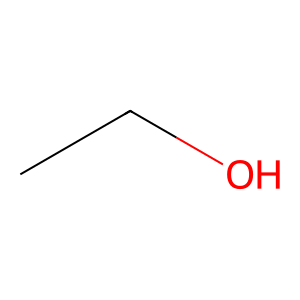

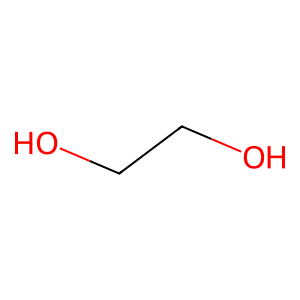

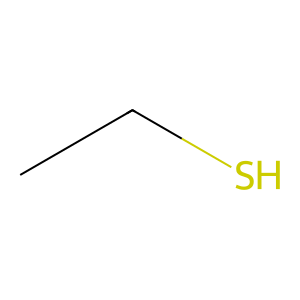

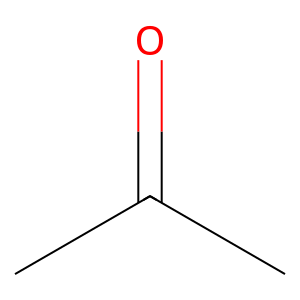

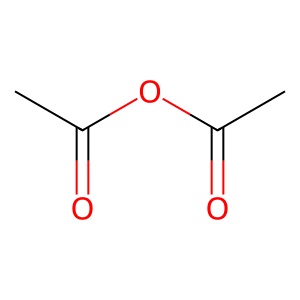

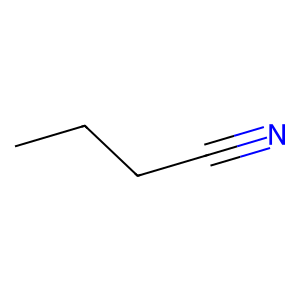

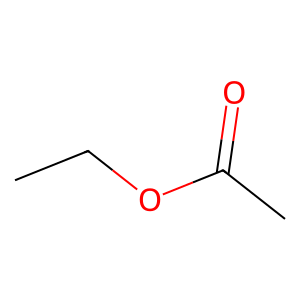

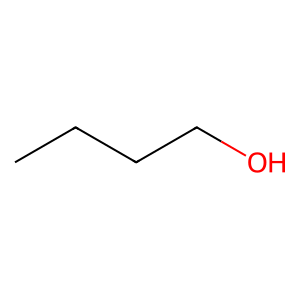

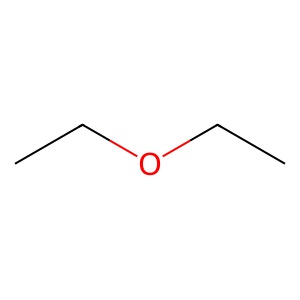

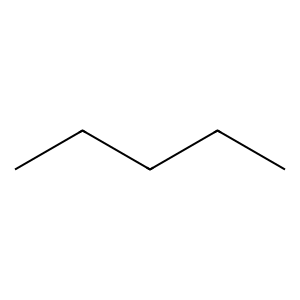

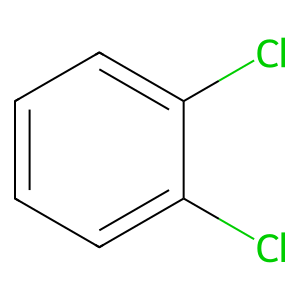

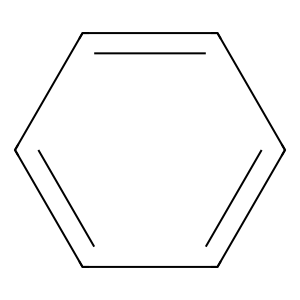

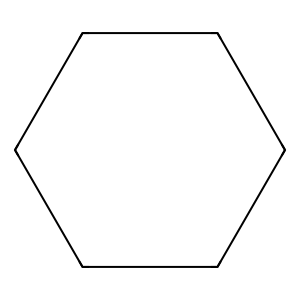

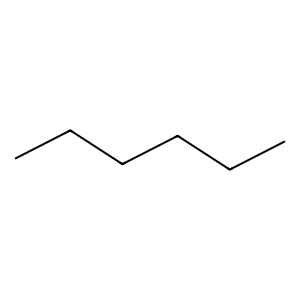

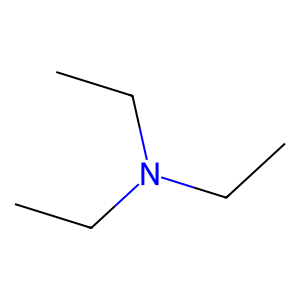

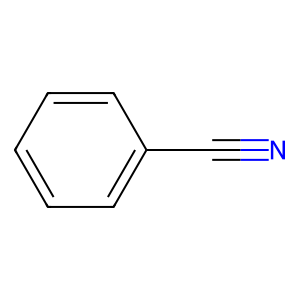

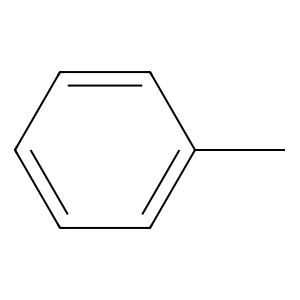

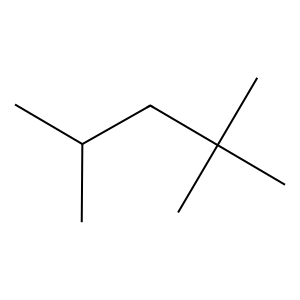

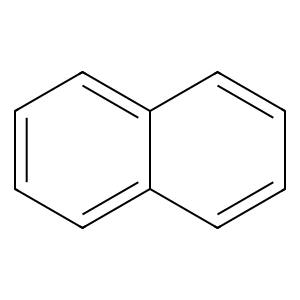

In [62]:
smiles_list = [
    COMMON_SOLVENTS.get(key, {}).get("SMILES", {}) for key in COMMON_SOLVENTS
]

print(smiles_list)

mols_dic = [Chem.MolFromSmiles(i) for i in smiles_list]

for mol in mols_dic:
    img = MolToImage(mol)
    display(img)

## Convert SDF to SMILES

In [63]:
suppl: Chem.SDMolSupplier = Chem.SDMolSupplier(f"{SDF_DIR.joinpath(file)}")

for mol in suppl:
    assert mol is not None

mols_sdf = [i for i in suppl]
print(f"The file '{file}' contains '{len(mols_sdf)}' molecule(s).")

assert len(mols_sdf) > 0

smiles_from_sdf = [Chem.MolToSmiles(mol) for mol in mols_sdf]
print(smiles_from_sdf)

The file 'SDF-to-SMILES.sdf' contains '30' molecule(s).
['CCl', 'ClCCl', 'ClC(Cl)Cl', 'ClC(Cl)(Cl)Cl', 'C[N+](=O)[O-]', 'CO', 'O=C(O)C(Cl)(Cl)Cl', 'O=C(O)C(F)(F)F', 'CC#N', 'ClCCCl', 'CC(=O)O', 'CCO', 'OCCO', 'CCS', 'CC(C)=O', 'CC(=O)OC(C)=O', 'CCCC#N', 'CCOC(C)=O', 'CCCCO', 'CCOCC', 'CCCCC', 'Clc1ccccc1Cl', 'c1ccccc1', 'C1CCCCC1', 'CCCCCC', 'CCN(CC)CC', 'N#Cc1ccccc1', 'Cc1ccccc1', 'CC(C)CC(C)(C)C', 'c1ccc2ccccc2c1']


### 1. Checks if SMILES of molecule from SDF is present in the dictionary
### 2. If True, Diamagnetic Susceptibility of the molecule is taken from the dictionary and added to the sum

In [64]:
smiles_to_diamag = {v["SMILES"]: v["DIAMAG_SUS"] for v in COMMON_SOLVENTS.values()}

sum_mol_diamag = 0

for smiles in smiles_from_sdf:
    in_dictionary = smiles in smiles_to_diamag

    print(f"Molecule: {smiles} | InDictionary: {in_dictionary}")

    if in_dictionary:
        sum_mol_diamag += smiles_to_diamag[smiles]
        print(round(sum_mol_diamag, 2))

print(f"Total: {round(sum_mol_diamag, 2)}*10^(-6) cm^3 mol^(-1)")


Molecule: CCl | InDictionary: True
-32.0
Molecule: ClCCl | InDictionary: True
-78.6
Molecule: ClC(Cl)Cl | InDictionary: True
-137.5
Molecule: ClC(Cl)(Cl)Cl | InDictionary: True
-204.3
Molecule: C[N+](=O)[O-] | InDictionary: True
-225.3
Molecule: CO | InDictionary: True
-246.7
Molecule: O=C(O)C(Cl)(Cl)Cl | InDictionary: True
-319.7
Molecule: O=C(O)C(F)(F)F | InDictionary: True
-363.0
Molecule: CC#N | InDictionary: True
-390.8
Molecule: ClCCCl | InDictionary: True
-450.4
Molecule: CC(=O)O | InDictionary: True
-482.2
Molecule: CCO | InDictionary: True
-515.9
Molecule: OCCO | InDictionary: True
-554.8
Molecule: CCS | InDictionary: True
-599.7
Molecule: CC(C)=O | InDictionary: True
-633.5
Molecule: CC(=O)OC(C)=O | InDictionary: True
-686.3
Molecule: CCCC#N | InDictionary: True
-736.7
Molecule: CCOC(C)=O | InDictionary: True
-790.8
Molecule: CCCCO | InDictionary: True
-847.2
Molecule: CCOCC | InDictionary: True
-902.7
Molecule: CCCCC | InDictionary: True
-964.2
Molecule: Clc1ccccc1Cl | InDic